In [261]:
# 1️  Import des bibliothèques
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

In [262]:
data = pd.read_csv("6_1_avocado.csv")

In [263]:
data.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [264]:
data["Date"] = pd.to_datetime(data["Date"])

# On prend une série unique : TotalUS + conventional
sub = data[(data["region"] == "Albany") & (data["type"] == "conventional")].copy()

# On garde seulement Date + AveragePrice
ts = sub.sort_values("Date").set_index("Date")["AveragePrice"]

# Fréquence hebdo (le dataset est hebdomadaire). On force une fréquence régulière.
ts = ts.asfreq("W-SUN")  # souvent les dates tombent sur dimanche
ts = ts.interpolate()    # au cas où il y a des trous

ts.name = "AveragePrice"
print(ts.head(), "\n---\n", ts.tail())

Date
2015-01-04    1.22
2015-01-11    1.24
2015-01-18    1.17
2015-01-25    1.06
2015-02-01    0.99
Freq: W-SUN, Name: AveragePrice, dtype: float64 
---
 Date
2018-02-25    1.28
2018-03-04    1.08
2018-03-11    1.12
2018-03-18    1.35
2018-03-25    1.57
Freq: W-SUN, Name: AveragePrice, dtype: float64


In [265]:
data['AveragePrice'] = data['AveragePrice'].fillna(0)


In [266]:
data.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


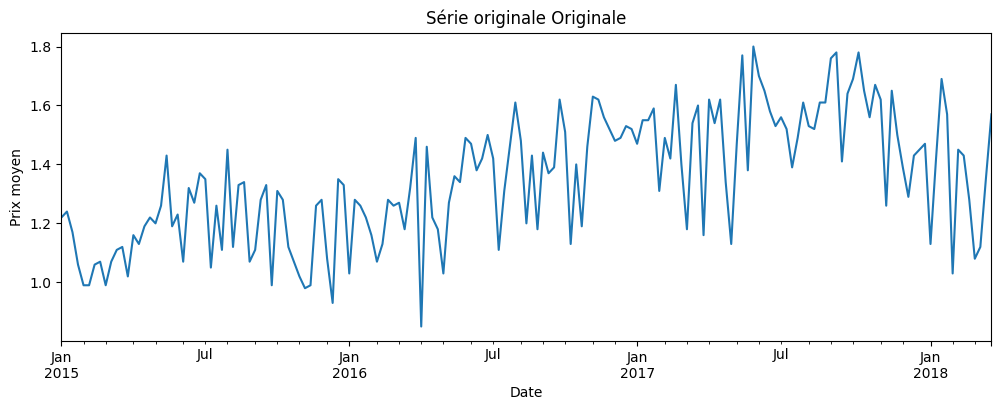

In [267]:
plt.figure(figsize=(12,4))
ts.plot()
plt.title("Série originale Originale")
plt.xlabel("Date")
plt.ylabel("Prix moyen")
plt.show()

In [268]:
ts.describe()

count    169.000000
mean       1.348757
std        0.212427
min        0.850000
25%        1.180000
50%        1.350000
75%        1.520000
max        1.800000
Name: AveragePrice, dtype: float64

In [269]:
ts.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 169 entries, 2015-01-04 to 2018-03-25
Freq: W-SUN
Series name: AveragePrice
Non-Null Count  Dtype  
--------------  -----  
169 non-null    float64
dtypes: float64(1)
memory usage: 2.6 KB


In [270]:
ts_df = ts.to_frame(name="AveragePrice")

print(type(ts_df))
print(ts_df.columns)
print(ts_df.head())


<class 'pandas.core.frame.DataFrame'>
Index(['AveragePrice'], dtype='object')
            AveragePrice
Date                    
2015-01-04          1.22
2015-01-11          1.24
2015-01-18          1.17
2015-01-25          1.06
2015-02-01          0.99


choix des paramètres p et q

In [271]:
def adf_test(x):
    # Si DataFrame -> prendre la colonne AveragePrice
    if isinstance(x, pd.DataFrame):
        s = x["AveragePrice"]
    else:  # sinon c'est une Series
        s = x

    s = s.dropna()
    result = adfuller(s, autolag="AIC")

    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Stationnaire" if result[1] < 0.05 else "NON stationnaire")

In [272]:
adf_test(ts_df)


ADF Statistic: -1.852093692560094
p-value: 0.3549221705413138
NON stationnaire


In [273]:
def difference(series,order):
    return series.diff(order).dropna()

In [274]:
ts_df["AveragePrice"] = np.log(ts_df["AveragePrice"])
data_diff = difference(ts_df,1)


In [275]:
adf_test(data_diff)

ADF Statistic: -8.380910232666801
p-value: 2.5116668082622183e-13
Stationnaire


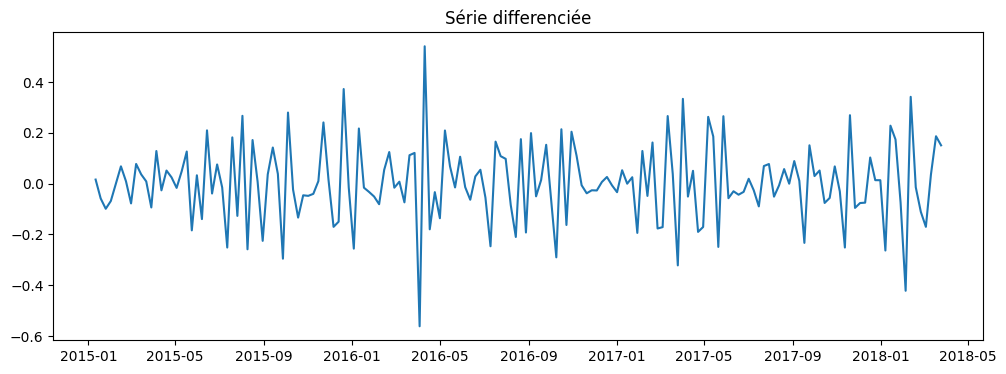

In [276]:
plt.figure(figsize=(12,4))
plt.plot(data_diff.index, data_diff["AveragePrice"])
plt.title("Série differenciée")
plt.show()

<Figure size 1000x400 with 0 Axes>

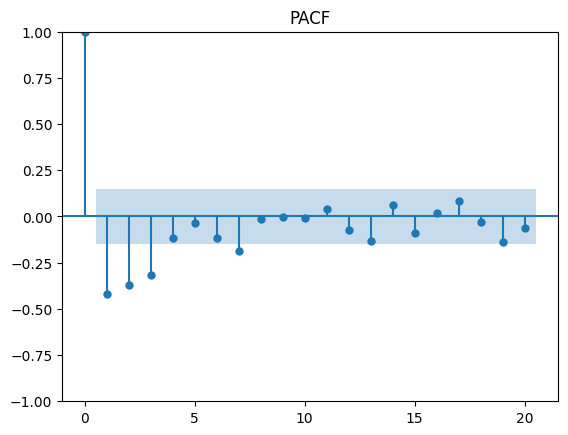

<Figure size 1000x400 with 0 Axes>

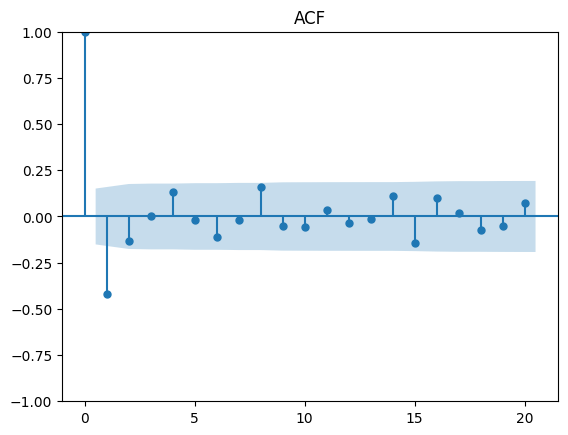

In [277]:
plt.figure(figsize=(10,4))
plot_pacf(data_diff["AveragePrice"], lags=20)
plt.title("PACF")
plt.show()
plt.figure(figsize=(10,4))
plot_acf(data_diff["AveragePrice"], lags=20)
plt.title("ACF")
plt.show()

p= 3 et q= 1

Réalisation du modèle ARIMA

In [278]:
num_split=int(ts_df.shape[0]*0.8)
train_set=ts.iloc[:num_split]
test_set=ts.iloc[num_split:]

In [279]:
model = ARIMA(train_set, order=(3,1,1))
model_fit = model.fit()


In [280]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           AveragePrice   No. Observations:                  135
Model:                 ARIMA(3, 1, 1)   Log Likelihood                  64.397
Date:                Wed, 14 Jan 2026   AIC                           -118.794
Time:                        10:30:03   BIC                           -104.305
Sample:                    01-04-2015   HQIC                          -112.906
                         - 07-30-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0102      0.132     -0.077      0.939      -0.269       0.249
ar.L2         -0.0873      0.099     -0.885      0.376      -0.281       0.106
ar.L3         -0.0111      0.105     -0.106      0.9

Auto ARIMA

In [281]:
from pmdarima import auto_arima

model_auto = auto_arima(
    train_set.to_frame()['AveragePrice'],
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=None,             # auto_arima détecte automatiquement 'd'
    seasonal=False,     # Si ta série a saisonnalité, mettre True et ajouter m=12
    stepwise=True,      # Recherche efficace
    suppress_warnings=True,
    trace=True          # Affiche le processus de sélection
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-54.477, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-83.130, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-126.014, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-56.447, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-124.433, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-124.464, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-122.027, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-124.051, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.667 seconds


In [282]:
print(model_auto.order)

(0, 1, 1)


In [283]:
predictions_auto = model_auto.predict(n_periods=len(test_set))
predictions_auto = pd.Series(predictions_auto, index=test_set.index)

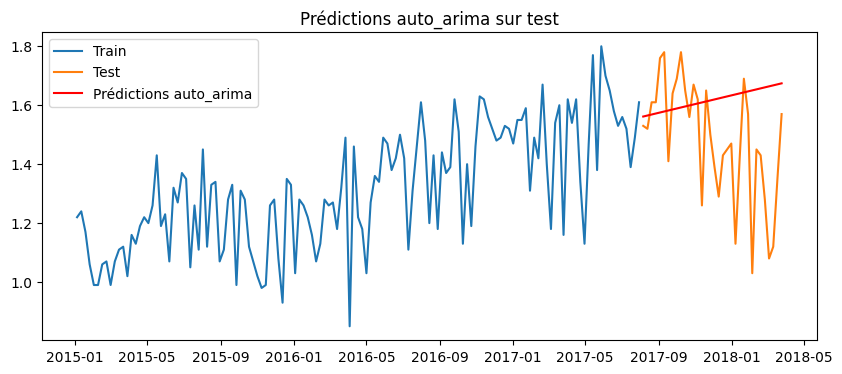

In [284]:
plt.figure(figsize=(10,4))
plt.plot(train_set.to_frame()['AveragePrice'], label='Train')
plt.plot(test_set.to_frame()['AveragePrice'], label='Test')
plt.plot(predictions_auto, color='red', label='Prédictions auto_arima')
plt.title("Prédictions auto_arima sur test")
plt.legend()
plt.show()

In [285]:
rmse = mean_squared_error(test_set,predictions_auto)
print(rmse)

0.06638006151359882


SARIMA

In [286]:
def adf_test(series):
    result = adfuller(series["AveragePrice"])
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] < 0.05:
        print(" Série stationnaire")
    else:
        print(" Série NON stationnaire")

In [287]:
adf_test(ts.to_frame())

ADF Statistic: -1.852093692560094
p-value: 0.3549221705413138
 Série NON stationnaire


In [288]:
def difference(series,order):
    return series.diff(order).dropna()

In [289]:
data_diff_1 = difference(ts.to_frame(),1)
#data_diff_2 = difference(data_diff_1,1)
# d = 2
adf_test(data_diff_1)

ADF Statistic: -8.602590372965045
p-value: 6.805498230360987e-14
 Série stationnaire


<Figure size 1000x400 with 0 Axes>

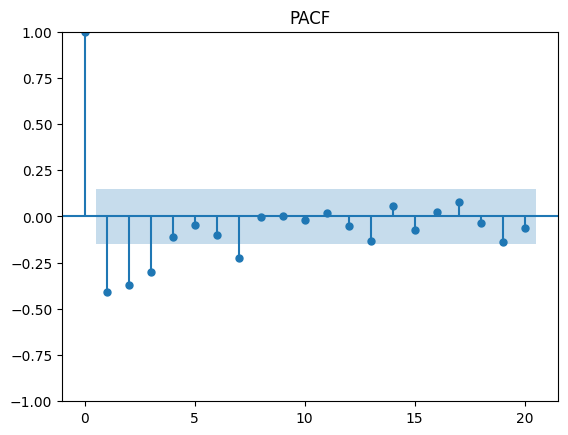

<Figure size 1000x400 with 0 Axes>

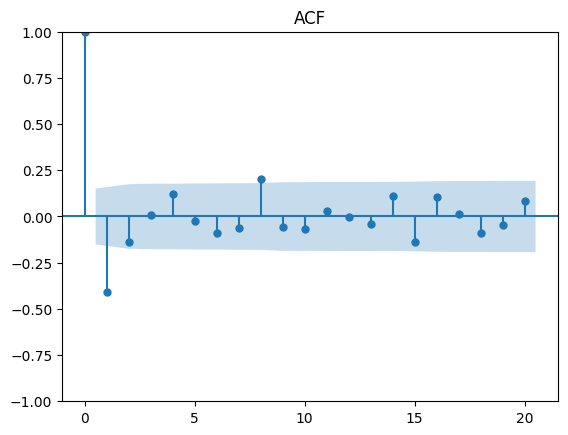

In [290]:
plt.figure(figsize=(10,4))
plot_pacf(data_diff_1["AveragePrice"], lags=20)
plt.title("PACF")
plt.show()
plt.figure(figsize=(10,4))
plot_acf(data_diff_1["AveragePrice"], lags=20)
plt.title("ACF")
plt.show()

p=3, q=1, d=1

In [291]:
s=7
data_saison = difference(data_diff_1,7)

In [292]:
# plt.figure(figsize=(12,4))
# plot_pacf(data_saison["AveragePrice"], lags=4*s)
# plt.title("PACF")
# plt.show()
# plt.figure(figsize=(12,4))
# plot_acf(data_saison["AveragePrice"], lags=4*s)
# plt.title("ACF")
# plt.show()

Taille série: 161 | max_lags autorisé: 28


<Figure size 1200x400 with 0 Axes>

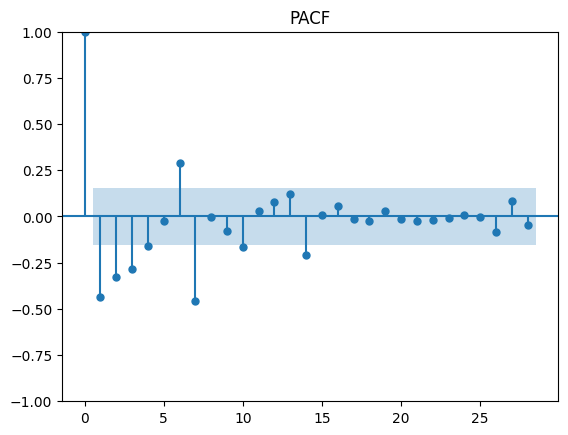

<Figure size 1200x400 with 0 Axes>

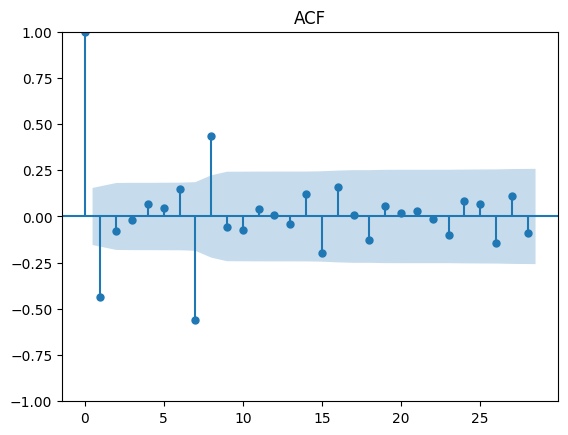

In [293]:
x = data_saison["AveragePrice"].dropna()

max_lags = 4*s  # contrainte pacf
print("Taille série:", len(x), "| max_lags autorisé:", max_lags)

plt.figure(figsize=(12,4))
plot_pacf(x, lags=max_lags, method="ywm")
plt.title("PACF")
plt.show()

plt.figure(figsize=(12,4))
plot_acf(x, lags=max_lags)
plt.title("ACF")
plt.show()

In [294]:
h = 12  # horizon de test (12 semaines)

train = ts.iloc[:-h]
test  = ts.iloc[-h:]

c:\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                     
Dep. Variable:                      AveragePrice   No. Observations:                  169
Model:             SARIMAX(3, 1, 1)x(2, 1, 1, 7)   Log Likelihood                  53.985
Date:                           Wed, 14 Jan 2026   AIC                            -91.969
Time:                                   10:32:12   BIC                            -68.211
Sample:                               01-04-2015   HQIC                           -82.315
                                    - 03-25-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2264      0.153     -1.479      0.139      -0.526       0.074
ar.L2         -0.3088      0.105     -2.939

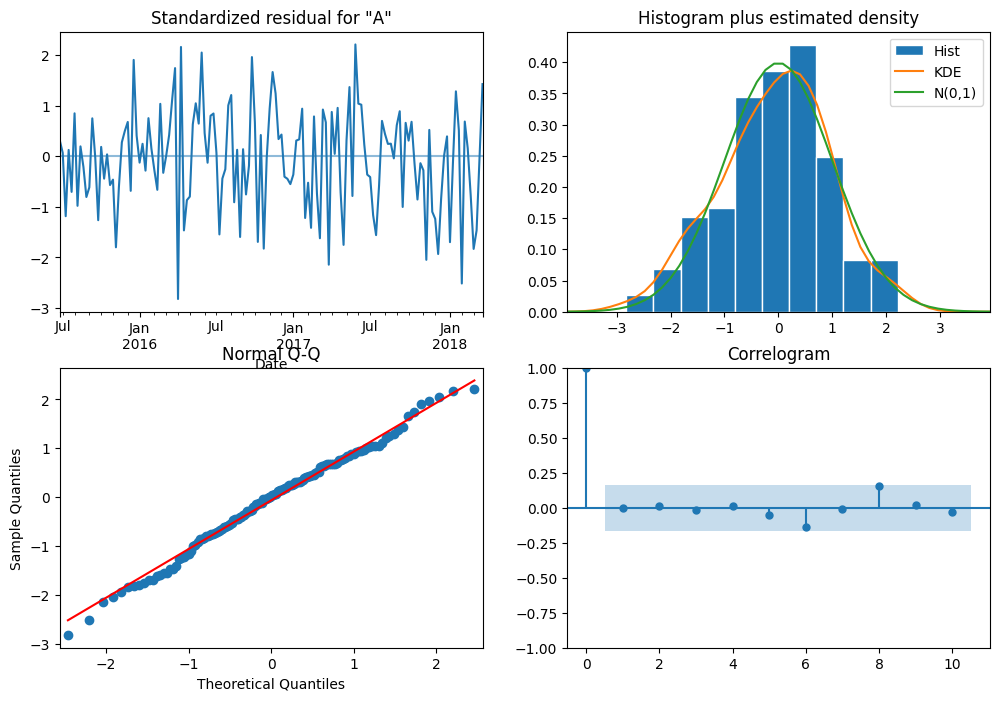

In [296]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

p, d, q = 3, 1, 1
P, D, Q = 2, 1, 1
 

model = SARIMAX(
    ts,
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit()

print(results.summary())
results.plot_diagnostics(figsize=(12,8))
plt.show()

In [ ]:
h = 12
pred = results.get_forecast(steps=h)
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int()


In [ ]:
rmse = np.sqrt(mean_squared_error(test, pred_mean))
print("RMSE du modèle SARIMAX :", rmse)


RMSE du modèle SARIMAX : 0.21846246643605072


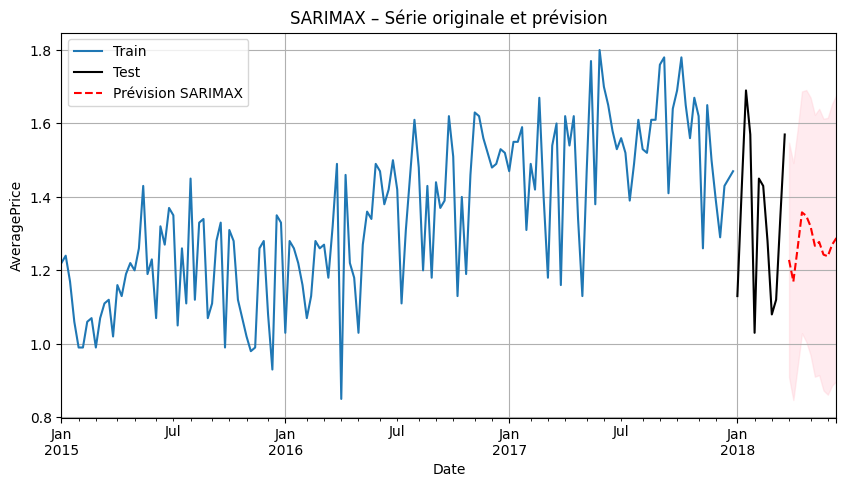

In [ ]:
plt.figure(figsize=(10,5))

# Série originale
train.plot(label="Train")
test.plot(label="Test", color="black")

# Prédictions
pred_mean.plot(label="Prévision SARIMAX", linestyle="--", color="red")

# Intervalle de confiance
plt.fill_between(
    pred_ci.index,
    pred_ci.iloc[:, 0],
    pred_ci.iloc[:, 1],
    color="pink",
    alpha=0.3
)

plt.title("SARIMAX – Série originale et prévision")
plt.xlabel("Date")
plt.ylabel("AveragePrice")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from statsmodels.tsa.seasonal import STL
stl = STL(ts.to_frame()['AveragePrice'], period=365)
result = stl.fit()

In [ ]:
trend = result.trend        # Tendance
seasonal = result.seasonal  # Saisonnalité
residual = result.resid  

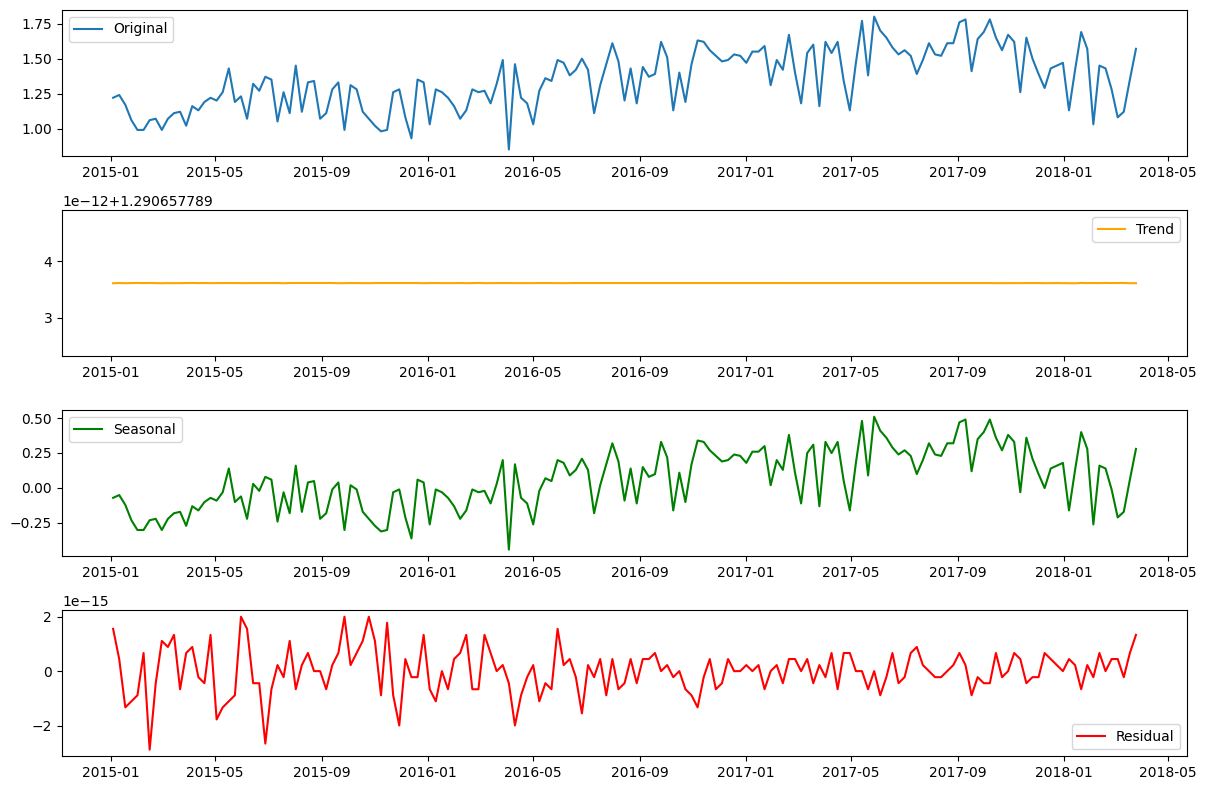

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(4,1,1)
plt.plot(ts.to_frame()['AveragePrice'], label='Original')
plt.legend()

plt.subplot(4,1,2)
plt.plot(trend, label='Trend', color='orange')
plt.legend()

plt.subplot(4,1,3)
plt.plot(seasonal, label='Seasonal', color='green')
plt.legend()

plt.subplot(4,1,4)
plt.plot(residual, label='Residual', color='red')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
s=12
data_saison1 = difference(data_diff_1,s)

Taille série: 156 | max_lags autorisé: 28


<Figure size 1200x400 with 0 Axes>

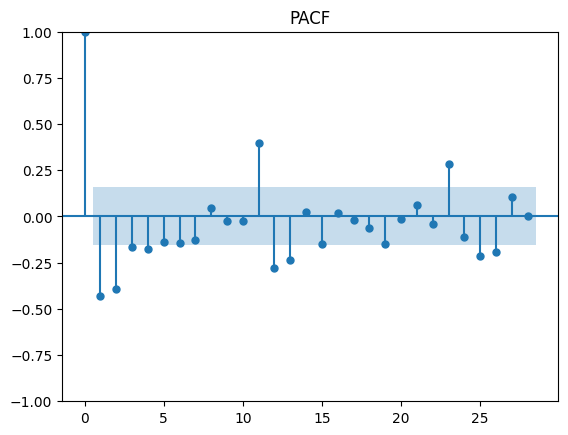

<Figure size 1200x400 with 0 Axes>

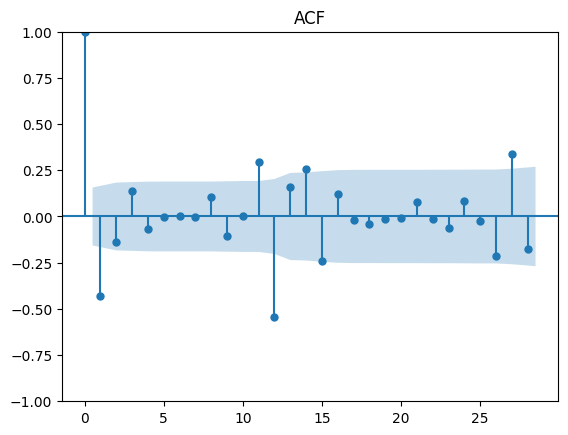

In [ ]:
x = data_saison1["AveragePrice"].dropna()

#max_lags = 4*s  # contrainte pacf
print("Taille série:", len(x), "| max_lags autorisé:", max_lags)

plt.figure(figsize=(12,4))
plot_pacf(x, lags=max_lags, method="ywm")
plt.title("PACF")
plt.show()

plt.figure(figsize=(12,4))
plot_acf(x, lags=max_lags)
plt.title("ACF")
plt.show()

c:\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


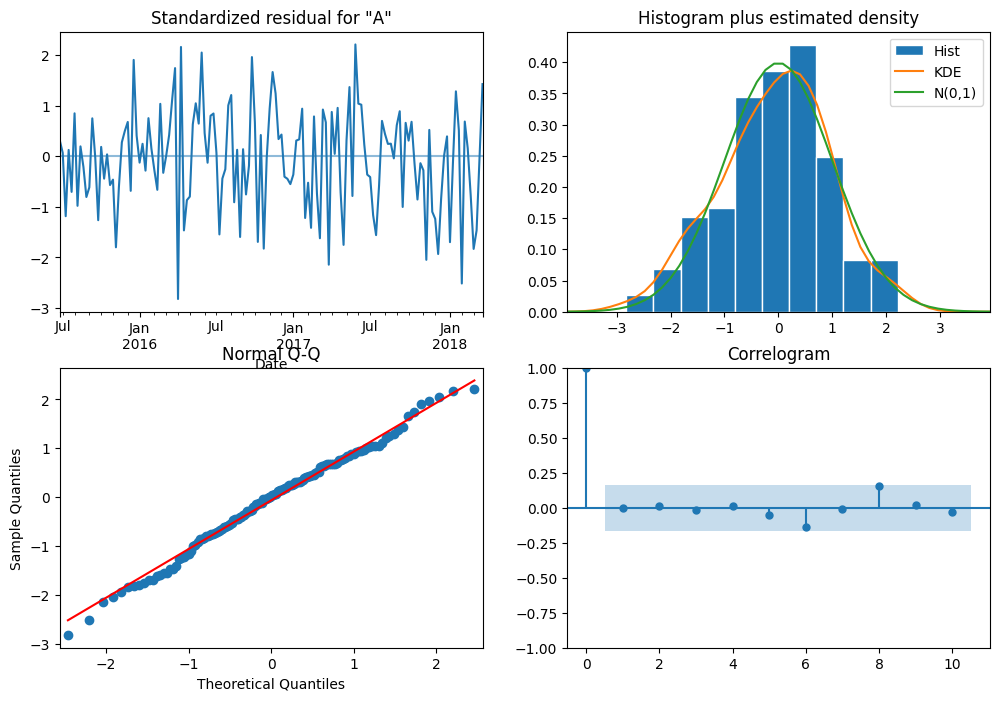

In [297]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

p, d, q = 3, 1, 1
P, D, Q = 2, 1, 1
 

model = SARIMAX(
    ts,
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit()
results.plot_diagnostics(figsize=(12,8))
plt.show()

In [298]:
s=52
data_saison2 = difference(data_diff_1,s)

Taille série: 116 | max_lags autorisé: 208


ValueError: Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 208 must be < 58.

<Figure size 1200x400 with 0 Axes>

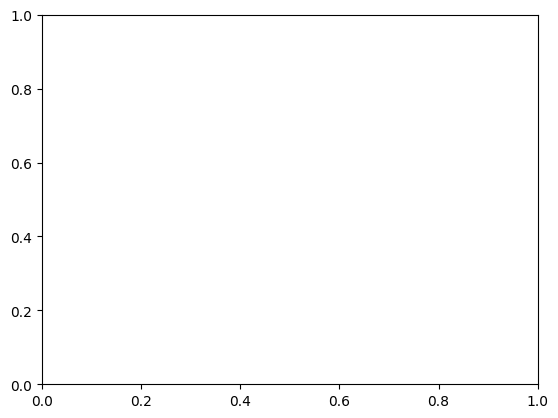

In [300]:
x = data_saison2["AveragePrice"].dropna()

max_lags = 4*52  # contrainte pacf
print("Taille série:", len(x), "| max_lags autorisé:", max_lags)

plt.figure(figsize=(12,4))
plot_pacf(x, lags=max_lags, method="ywm")
plt.title("PACF")
plt.show()

plt.figure(figsize=(12,4))
plot_acf(x, lags=max_lags)
plt.title("ACF")
plt.show()